In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 500)
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

In [2]:
url ="C:/Users/Dell/Desktop/Form--main/Dataset/Suspicious Communication on Social Platforms.csv"
df = pd.read_csv(url)
df.head()

,comments,tagging
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook Rengel the Dems are so fucking corrupt it's a joke. Make Republicans look like ...,1
2,why did you fuck it up. I could do it all day too. Let's do it when you have an hour. Ping me later to sched writing a book here.,1
3,Dude they dont finish enclosing the fucking showers. I hate half assed jobs. Whats the reasononing behind it? Makes no sense.,1
4,WTF are you talking about Men? No men thats not a menage that's just gay.,1


In [3]:
df.shape

(20001, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  20001 non-null  object
 1   tagging   20001 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


### Null Count = 0

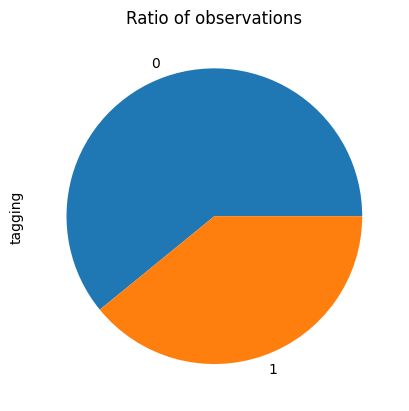

In [5]:
df['tagging'].value_counts(normalize=True).plot(kind='pie', title='Ratio of observations')
plt.show()

# Preprocessing

In [6]:
#Function to tokenize the text and remove punctuations
import string
def tokenize_remove_punctuations(text):
    clean_text = []
    text = text.split(" ")
    for word in text:
        word = list(word)
        new_word = []
        for c in word:
            if c not in string.punctuation:
                new_word.append(c)
        word = "".join(new_word)
        if len(word)>0:
            clean_text.append(word)
    return clean_text

In [7]:
trial_text = "hello @anyone reading? wt is the name of am in that this  ??!@"
trial_text = tokenize_remove_punctuations(trial_text)
print(trial_text)

['hello', 'anyone', 'reading', 'wt', 'is', 'the', 'name', 'of', 'am', 'in', 'that', 'this']


In [8]:
#Function to remove english stopwords
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word not in stopwords:
            clean_text.append(word)
    return clean_text

In [9]:
trial_text = remove_stopwords(trial_text)
print(trial_text)

['hello', 'anyone', 'reading', 'wt', 'name']


In [10]:
#Part Of Speech Tagging
def pos_tagging(text):
    tagged = nltk.pos_tag(text)
    return tagged    

In [11]:
pos_tag = pos_tagging(trial_text)
print(pos_tag)

[('hello', 'NN'), ('anyone', 'NN'), ('reading', 'VBG'), ('wt', 'NNS'), ('name', 'NN')]


In [12]:
#Function to get wordnet tagging for POS
from nltk.corpus import wordnet
def get_wordnet(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
#Function to lemmatize words
from nltk.stem import WordNetLemmatizer
def lemmatize(pos_tags):
    lemmatized_text = []
    for t in pos_tags:
        word = WordNetLemmatizer().lemmatize(t[0],get_wordnet(t[1]))
        lemmatized_text.append(word)
    return lemmatized_text
    

In [14]:
def clean_text(text):
    text = str(text)
    #Converting text to lower-case
    text = text.lower()
    #Tokenize and remove punctuations from the text
    text = tokenize_remove_punctuations(text)
    #Remove words containing numericals
    text = [word for word in text if not any(c.isdigit() for c in word)]
    #Remove stopwords
    text = remove_stopwords(text)
    #Remove empty tokens
    text = [ t for t in text if len(t) > 0]
    #POS tagging
    pos_tags = pos_tagging(text)
    #Lemmatize text
    text = lemmatize(pos_tags)
    #Remove words with only one letter
    text = [ t for t in text if len(t)>1]
    #Join all words
    text = " ".join(text)
    return text

In [15]:
print(clean_text("What is y0ur names? THis is a cat!! 12?"))

name cat


In [16]:
print(clean_text("Are you going to zoo?"))

go zoo


### Getting preprocessed comments

In [17]:

df['Processed_Comment'] = df['comments'].map(clean_text)

In [18]:
#Splitting dataset for training and testing(80:20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Comment'], 
                                                    df['tagging'], 
                                                    random_state=42,test_size=0.20)


In [19]:
#Using CountVectorizer to get feature vectors
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()
X_train = count_vector.fit_transform(X_train)
X_test = count_vector.transform(X_test)

In [20]:
len(count_vector.vocabulary_)

13816

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [22]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Using GridSearchCV to find best parameters

In [23]:
model_params = {
    'LinearSVC': {
        'model': LinearSVC(max_iter=1000000,random_state=42),
        'params' : {
            'C': [0.1,1,5,10,20],
        }  
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params' : {
            'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False],
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(random_state=42, multi_class='ovr',max_iter=1000000),
        'params': {
            'C': [1,5,10],
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(p=2 ),
        'params' : {
            'n_neighbors': [5,9,11,23],
              'weights' : ['uniform', 'distance'],
              'metric' : ['euclidean', 'manhattan', 'minkowski'],
        }
    }
}

In [47]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
params = pd.DataFrame(scores,columns=['model','best_score','best_params'])
params

,model,best_score,best_params
0,LinearSVC,0.830562,{'C': 1}
1,MultinomialNB,0.765375,"{'alpha': 0.5, 'fit_prior': True}"
2,logistic_regression,0.832188,"{'C': 10, 'solver': 'newton-cg'}"
3,KNeighborsClassifier,0.782563,"{'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'distance'}"


In [25]:
results =[]

# KNN

In [26]:
model1= KNeighborsClassifier(n_neighbors=23, metric='euclidean',weights = 'distance')  
model1.fit(X_train, y_train)  

KNeighborsClassifier(metric='euclidean', n_neighbors=23, weights='distance')

In [27]:
predictions_test = model1.predict(X_test)
predictions_train = model1.predict(X_train)
temp = ['KNeighborsClassifier']
temp.append(accuracy_score(predictions_train,y_train))
temp.append(recall_score(predictions_train,y_train))
temp.append(f1_score(predictions_train,y_train))
temp.append(precision_score(predictions_train,y_train))
temp.append(accuracy_score(predictions_test,y_test))
temp.append(recall_score(predictions_test,y_test))
temp.append(f1_score(predictions_test,y_test))
temp.append(precision_score(predictions_test,y_test))
results.append(temp)

In [28]:
confusion = confusion_matrix(predictions_test,y_test)
print(confusion)

[[1678   80]
 [ 746 1497]]


# Logistic Regression

In [29]:
model2 = LogisticRegression(C=10, random_state=42, solver='lbfgs', multi_class='ovr',max_iter=1000000)
model2.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000000, multi_class='ovr', random_state=42)

In [30]:
predictions_test = model2.predict(X_test)
predictions_train = model2.predict(X_train)
temp = ['LogisticRegression']
temp.append(accuracy_score(predictions_train,y_train))
temp.append(recall_score(predictions_train,y_train))
temp.append(f1_score(predictions_train,y_train))
temp.append(precision_score(predictions_train,y_train))
temp.append(accuracy_score(predictions_test,y_test))
temp.append(recall_score(predictions_test,y_test))
temp.append(f1_score(predictions_test,y_test))
temp.append(precision_score(predictions_test,y_test))
results.append(temp)

In [31]:
confusion = confusion_matrix(predictions_test,y_test)
print(confusion)

[[1983  163]
 [ 441 1414]]


# Naive Bayes

In [32]:
model3 = MultinomialNB(alpha = 0.5)
model3.fit(X_train, y_train)

MultinomialNB(alpha=0.5)

In [33]:
predictions_test = model3.predict(X_test)
predictions_train = model3.predict(X_train)
temp = ['MultinomialNB']
temp.append(accuracy_score(predictions_train,y_train))
temp.append(recall_score(predictions_train,y_train))
temp.append(f1_score(predictions_train,y_train))
temp.append(precision_score(predictions_train,y_train))
temp.append(accuracy_score(predictions_test,y_test))
temp.append(recall_score(predictions_test,y_test))
temp.append(f1_score(predictions_test,y_test))
temp.append(precision_score(predictions_test,y_test))
results.append(temp)

In [34]:
confusion = confusion_matrix(predictions_test,y_test)
print(confusion)

[[1986  370]
 [ 438 1207]]


# Linear SVC

In [35]:
model4 = LinearSVC(C = 1, max_iter=1000000,random_state=42)
model4.fit(X_train, y_train)

LinearSVC(C=1, max_iter=1000000, random_state=42)

In [36]:
predictions_test = model4.predict(X_test)
predictions_train = model4.predict(X_train)
temp = ['LinearSVC']
temp.append(accuracy_score(predictions_train,y_train))
temp.append(recall_score(predictions_train,y_train))
temp.append(f1_score(predictions_train,y_train))
temp.append(precision_score(predictions_train,y_train))
temp.append(accuracy_score(predictions_test,y_test))
temp.append(recall_score(predictions_test,y_test))
temp.append(f1_score(predictions_test,y_test))
temp.append(precision_score(predictions_test,y_test))
results.append(temp)

In [37]:
confusion = confusion_matrix(predictions_test,y_test)
print(confusion)

[[1967  162]
 [ 457 1415]]


# Summary

In [38]:
results = pd.DataFrame(results, columns = ['Algorithm','Accuracy Score : Train', 'Recall Score : Train','F1-Score :Train','Precision Score :Train','Accuracy Score : Test', 'Recall Score : Test','F1-Score : Test','Precision Score : Test'])
results

,Algorithm,Accuracy Score : Train,Recall Score : Train,F1-Score :Train,Precision Score :Train,Accuracy Score : Test,Recall Score : Test,F1-Score : Test,Precision Score : Test
0,KNeighborsClassifier,0.993625,0.989482,0.991853,0.994235,0.793552,0.667410,0.783770,0.949271
1,LogisticRegression,0.964187,0.956683,0.953994,0.951321,0.849038,0.762264,0.824009,0.896639
2,MultinomialNB,0.893938,0.873767,0.862357,0.851241,0.798050,0.733739,0.749224,0.765377
3,LinearSVC,0.963938,0.954750,0.953755,0.952762,0.845289,0.755876,0.820528,0.897273


# Saving models as pickle files

In [39]:
import pickle


In [40]:
pickle_out = open("vectorizer.pkl","wb")
pickle.dump(count_vector, pickle_out)
pickle_out.close()

In [41]:
pickle_out = open("LinearSVC.pkl","wb")
pickle.dump(model4, pickle_out)
pickle_out.close()

In [42]:
pickle_out = open("MultinomialNB.pkl","wb")
pickle.dump(model3, pickle_out)
pickle_out.close()

In [43]:
pickle_out = open("LogisticRegression.pkl","wb")
pickle.dump(model2, pickle_out)
pickle_out.close()

In [44]:
pickle_out = open("KNeighborsClassifier.pkl","wb")
pickle.dump(model1, pickle_out)
pickle_out.close()

In [45]:
import pickle

pickle_out = open("results.pkl", "wb")
pickle.dump(results, pickle_out)
pickle_out.close()


In [46]:
pickle_out = open("results_updated.pkl", "wb")
pickle.dump(results, pickle_out)
pickle_out.close()